In [1]:
# import library crawling
import tweepy
import csv
import string
import pandas as pd

# import library preprocessing
import ast 
import re #regex library
import preprocessor as p
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

# import library naive bayes clasifier
import numpy as np
import joblib
import pickle
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

[nltk_data] Downloading package punkt to C:\Users\RIDHO-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\RIDHO-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


# Crawling Data

In [90]:
#autentikasi
consumer_key = "GKtBQUKG9P7gPb629k4VTXYLR"
consumer_secret = "sIy9UnygHFNNm10JJ39Nc63UNM6VFG4lfZaRVpmF9nguK031LW"
access_token = "1191685350994767872-CnsLMvZxxDqdOMdSwRBx7LPvoG7zKl"
access_token_secret = "fblIxURhznuMKB8d9cIPHLcHqBEZZog3fNG4FDnjIzDk0"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [91]:
def scraptweets(search_words, date_since, date_until):

    db_tweets = pd.DataFrame(columns=['username', 'tweetcreatedts', 'tweet'])

    tweets = tweepy.Cursor(
                    api.search_tweets, q=search_words, lang="id", 
                    since=date_since, until=date_until, tweet_mode='extended').items(1000)

    tweet_list = [tweet for tweet in tweets]

    for tweet in tweet_list:
        username = tweet.user.screen_name
        tweetcreatedts = tweet.created_at

        try:
            tweet = tweet.retweeted_status.full_text
        except AttributeError:
            tweet = tweet.full_text

        ith_tweet = [username, tweetcreatedts, tweet]

        db_tweets.loc[len(db_tweets)] = ith_tweet
    
    print('Proses Crawling Selesai, Total Data Sebanyak', len(db_tweets))
    filename = 'dataset uji/dataset-crawling.csv'
    db_tweets.to_csv(filename, index=False)

### Masukkan kata kunci dan rentang waktu 

In [93]:
search_words = "Sekolah offline -filter:retweets"
date_since = "2022-07-14"
date_until = "2022-07-18"

scraptweets(search_words, date_since, date_until)

Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since


Proses Crawling Selesai, Total Data Sebanyak 233


In [94]:
data_twt = pd.read_csv("dataset uji/dataset-crawling.csv")

In [98]:
data_twt = pd.read_csv("dataset/dataset-Nolabel-1200.csv")

In [2]:
data_twt = pd.read_csv("NewDataset/Dataset-label.csv")

In [3]:
# data_twt = pd.read_csv("dataset/dataset 2022/sekolah offline-13juni2022.csv")

In [4]:
data_twt

,tweet,label_sentimen
0,ASTAGAAAA BARU INGET SEKARANG SEKOLAH OFFLINE,-1
1,"Yg udh sekolah offline, lama lama bosan gsi se...",-1
2,@jinhwanchy Wah udah sekolah offline? Semangat...,1
3,"@Fajri_UN1TY Haii juga, yuk yg sekolah offline...",1
4,Sch! Hai gais hari ini sender PTM untuk yg per...,-1
...,...,...
2188,sekolah ku udah mulai offline dari maret dann ...,0
2189,mana udah offline sekolah,0
2190,gue kira senin bakal sekolah offline ternyata ...,0
2191,art! curhat dkit sender akhir2 ini capek bgt s...,1


# Preprocessing

## Case Folding

In [5]:
data_twt['tweet_cf'] = data_twt['tweet'].str.lower()

print('Case Folding Result : \n')
print(data_twt['tweet_cf'].head(5))
print('\n\n\n')

Case Folding Result : 

0        astagaaaa baru inget sekarang sekolah offline
1    yg udh sekolah offline, lama lama bosan gsi se...
2    @jinhwanchy wah udah sekolah offline? semangat...
3    @fajri_un1ty haii juga, yuk yg sekolah offline...
4    sch! hai gais hari ini sender ptm untuk yg per...
Name: tweet_cf, dtype: object






## Tokenizing

In [6]:
def remove_tweet_special(text):
    # menghapus tab, new line, dan back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # menghapus non ASCII (emotikon, tulisan china, dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # menghapus mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # menghapus URL yg tidak lengkap
    return text.replace("http://", " ").replace("https://", " ")
                
data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_tweet_special)

#menghapus nomor
def remove_number(text):
    return  re.sub(r"\d+", "", text)

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_number)

#menghapus tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_punctuation)

#menghapus spasi awal dan akhir
def remove_whitespace_LT(text):
    return text.strip()

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_whitespace_LT)

#menghapus spasi yg dobel menjadi satu spasi
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

data_twt['tweet_cf'] = data_twt['tweet_cf'].apply(remove_whitespace_multiple)

# menghapus karakter tunggal
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

data_twt['tweet_clean'] = data_twt['tweet_cf'].apply(remove_singl_char)

def preprocessing_data(x):
    return p.clean(x)

data_twt['tweet_clean'] = data_twt['tweet_cf'].apply(preprocessing_data)

def tokenize_data(x):
    return p.tokenize(x)

data_twt['tweet_clean'] = data_twt['tweet_clean'].apply(tokenize_data)

In [7]:
alay_dict = pd.read_csv('kamus/kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

data_twt['tweet_clean_alay'] = data_twt['tweet_clean'].apply(normalize_alay) 
data_twt.drop_duplicates(keep=False,inplace=True)

In [8]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data_twt['tweet_token'] = data_twt['tweet_clean_alay'].apply(word_tokenize_wrapper)

## Stopword Removal

In [9]:
from nltk.corpus import stopwords
print(set(stopwords.words('Indonesian')))

{'lainnya', 'kalaulah', 'satu', 'cukuplah', 'tadi', 'disebutkan', 'sepihak', 'lima', 'terlihat', 'tanpa', 'begitukah', 'diperbuat', 'ialah', 'sendirinya', 'bermacam', 'dimulailah', 'menjawab', 'mengenai', 'dia', 'hendaklah', 'mula', 'menginginkan', 'terhadap', 'baru', 'yang', 'berakhirlah', 'selanjutnya', 'sekitar', 'soal', 'naik', 'memulai', 'diri', 'bekerja', 'belakang', 'antara', 'harusnya', 'jawab', 'menantikan', 'ketika', 'malah', 'sesampai', 'sekurangnya', 'diberi', 'diberikan', 'apatah', 'hendak', 'guna', 'bagi', 'manakala', 'siap', 'semakin', 'serupa', 'tersampaikan', 'ataukah', 'juga', 'berlalu', 'toh', 'memintakan', 'baik', 'akan', 'didapat', 'bisakah', 'mengingat', 'agak', 'bakal', 'bukanlah', 'meyakini', 'diibaratkannya', 'memberi', 'tentulah', 'sesaat', 'diakhiri', 'membuat', 'dekat', 'kiranya', 'persoalan', 'tentunya', 'disebut', 'masing', 'dimulainya', 'diingatkan', 'tetap', 'bukankah', 'tegasnya', 'semata-mata', 'semisal', 'semacam', 'seingat', 'mempersiapkan', 'kepadan

In [10]:
# list stopword indonesia dari library nltk
list_stopwords = stopwords.words('indonesian')
print(len(list_stopwords))

# menambah stopword manual
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])
len(list_stopwords)

# menambah stopword dari file luar
txt_stopword = pd.read_csv("kamus/stopword.csv", names= ["stopwords"], header = None)

# konversi stopword string ke list dan menambah stopword tambahan
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
len(list_stopwords)
# ---------------------------------------------------------------------------------------

# konversi list to dictionary
list_stopwords = set(list_stopwords)


#menghapus stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data_twt['tweet_stopword'] = data_twt['tweet_token'].apply(stopwords_removal) 


print(data_twt['tweet_stopword'])

758
0                              [astaga, sekolah, offline]
1       [sekolah, offline, bosan, sekolah, offline, gu...
2                    [sekolah, offline, semangat, jojooo]
3       [unty, hai, yuk, sekolah, offline, kayak, sema...
4       [sch, hai, gais, sender, ptm, kali, sekolah, a...
                              ...                        
2188    [sekolah, ku, offline, maret, enak, offline, o...
2189                                   [offline, sekolah]
2190               [gue, senin, sekolah, offline, online]
2191    [art, curhat, dkit, sender, cape, banget, seko...
2192    [kelas, dibolehin, sekolah, offline, gue, kete...
Name: tweet_stopword, Length: 2193, dtype: object


In [11]:
# normalisasi kata

def normalisasi(tweet):
    kamus_slangword = eval(open("kamus/combined_slang_words.txt").read()) # Membuka dictionary slangword
    pattern = re.compile(r'\b( ' + '|'.join (kamus_slangword.keys())+r')\b') # Search pola kata (contoh kpn -> kapan)
    content = []
    for kata in tweet:
        filteredSlang = pattern.sub(lambda x: kamus_slangword[x.group()],kata) # Replace slangword berdasarkan pola review yg telah ditentukan
        content.append(filteredSlang.lower())
    tweet = content
    return tweet
data_twt['tweet_normalisasi'] = data_twt['tweet_stopword'].apply(normalisasi)
print(data_twt['tweet_normalisasi'])

0                              [astaga, sekolah, offline]
1       [sekolah, offline, bosan, sekolah, offline, sa...
2                    [sekolah, offline, semangat, jojooo]
3       [unty, hai, yuk, sekolah, offline, kayak, sema...
4       [sch, hai, teman teman, sender, ptm, kali, sek...
                              ...                        
2188    [sekolah, ku, offline, maret, enak, offline, d...
2189                                   [offline, sekolah]
2190              [saya, senin, sekolah, offline, daring]
2191    [art, curhat, dkit, sender, capek, banget, sek...
2192    [kelas, dibolehin, sekolah, offline, saya, ket...
Name: tweet_normalisasi, Length: 2193, dtype: object


## Stemming

In [12]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in data_twt['tweet_normalisasi']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

data_twt['tweet_stemming'] = data_twt['tweet_normalisasi'].swifter.apply(get_stemmed_term)
print(data_twt['tweet_stemming'])

4767
------------------------


Pandas Apply:   0%|          | 0/2193 [00:00<?, ?it/s]

0                              [astaga, sekolah, offline]
1       [sekolah, offline, bosan, sekolah, offline, sa...
2                    [sekolah, offline, semangat, jojooo]
3       [unty, hai, yuk, sekolah, offline, kayak, sema...
4       [sch, hai, teman teman, sender, ptm, kali, sek...
                              ...                        
2188    [sekolah, ku, offline, maret, enak, offline, d...
2189                                   [offline, sekolah]
2190              [saya, senin, sekolah, offline, daring]
2191    [art, curhat, dkit, sender, capek, banget, sek...
2192    [kelas, dibolehin, sekolah, offline, saya, ket...
Name: tweet_stemming, Length: 2193, dtype: object


In [13]:
df = pd.DataFrame(data_twt)
df['tweet_stemming'] = df['tweet_stemming'].apply(str)

In [14]:
def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
data_twt["tweet_bersih"] = data_twt["tweet_stemming"].apply(join_text_list)

In [15]:
data_twt

,tweet,label_sentimen,tweet_cf,tweet_clean,tweet_clean_alay,tweet_token,tweet_stopword,tweet_normalisasi,tweet_stemming,tweet_bersih
0,ASTAGAAAA BARU INGET SEKARANG SEKOLAH OFFLINE,-1,astagaaaa baru inget sekarang sekolah offline,astagaaaa baru inget sekarang sekolah offline,astaga baru ingat sekarang sekolah offline,"[astaga, baru, ingat, sekarang, sekolah, offline]","[astaga, sekolah, offline]","[astaga, sekolah, offline]","['astaga', 'sekolah', 'offline']",astaga sekolah offline
1,"Yg udh sekolah offline, lama lama bosan gsi se...",-1,yg udh sekolah offline lama lama bosan gsi sek...,yg udh sekolah offline lama lama bosan gsi sek...,yang sudah sekolah offline lama lama bosan tid...,"[yang, sudah, sekolah, offline, lama, lama, bo...","[sekolah, offline, bosan, sekolah, offline, gu...","[sekolah, offline, bosan, sekolah, offline, sa...","['sekolah', 'offline', 'bosan', 'sekolah', 'of...",sekolah offline bosan sekolah offline saya bosan
2,@jinhwanchy Wah udah sekolah offline? Semangat...,1,wah udah sekolah offline semangat jojooo,wah udah sekolah offline semangat jojooo,wah sudah sekolah offline semangat jojooo,"[wah, sudah, sekolah, offline, semangat, jojooo]","[sekolah, offline, semangat, jojooo]","[sekolah, offline, semangat, jojooo]","['sekolah', 'offline', 'semangat', 'jojooo']",sekolah offline semangat jojooo
3,"@Fajri_UN1TY Haii juga, yuk yg sekolah offline...",1,unty haii juga yuk yg sekolah offline kayak ak...,unty haii juga yuk yg sekolah offline kayak ak...,unty hai juga yuk yang sekolah offline kayak a...,"[unty, hai, juga, yuk, yang, sekolah, offline,...","[unty, hai, yuk, sekolah, offline, kayak, sema...","[unty, hai, yuk, sekolah, offline, kayak, sema...","['unty', 'hai', 'yuk', 'sekolah', 'offline', '...",unty hai yuk sekolah offline kayak semangat aj...
4,Sch! Hai gais hari ini sender PTM untuk yg per...,-1,sch hai gais hari ini sender ptm untuk yg pert...,sch hai gais hari ini sender ptm untuk yg pert...,sch hai gais hari ini sender ptm untuk yang pe...,"[sch, hai, gais, hari, ini, sender, ptm, untuk...","[sch, hai, gais, sender, ptm, kali, sekolah, a...","[sch, hai, teman teman, sender, ptm, kali, sek...","['sch', 'hai', 'teman teman', 'sender', 'ptm',...",sch hai teman teman sender ptm kali sekolah al...
...,...,...,...,...,...,...,...,...,...,...
2188,sekolah ku udah mulai offline dari maret dann ...,0,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku sudah mulai offline dari maret dan ...,"[sekolah, ku, sudah, mulai, offline, dari, mar...","[sekolah, ku, offline, maret, enak, offline, o...","[sekolah, ku, offline, maret, enak, offline, d...","['sekolah', 'ku', 'offline', 'maret', 'enak', ...",sekolah ku offline maret enak offline daring t...
2189,mana udah offline sekolah,0,mana udah offline sekolah,mana udah offline sekolah,mana sudah offline sekolah,"[mana, sudah, offline, sekolah]","[offline, sekolah]","[offline, sekolah]","['offline', 'sekolah']",offline sekolah
2190,gue kira senin bakal sekolah offline ternyata ...,0,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,"[gue, kira, senin, bakal, sekolah, offline, te...","[gue, senin, sekolah, offline, online]","[saya, senin, sekolah, offline, daring]","['saya', 'senin', 'sekolah', 'offline', 'daring']",saya senin sekolah offline daring
2191,art! curhat dkit sender akhir2 ini capek bgt s...,1,art curhat dkit sender akhir ini capek bgt stl...,art curhat dkit sender akhir ini capek bgt stl...,art curhat dkit sender akhir ini cape banget s...,"[art, curhat, dkit, sender, akhir, ini, cape, ...","[art, curhat, dkit, sender, cape, banget, seko...","[art, curhat, dkit, sender, capek, banget, sek...","['art', 'curhat', 'dkit', 'sender', 'capek', '...",art curhat dkit sender capek banget sekolah of...


# Naive Bayes Classifier

In [16]:
with open('model/model_analisis.pkl', 'rb') as r:
    model_predict = pickle.load(r)

with open('model/tfidf.pkl', 'rb') as t:
    model_tfidf = pickle.load(t)

In [17]:
# with open('model/model_analisis.pkl', 'rb') as r:
#     model_predict = pickle.load(r)

# with open('model/count_vector.pkl', 'rb') as t:
#     model_tfidf = pickle.load(t)

In [18]:
transform_tfidf = model_tfidf.transform(data_twt['tweet_bersih'])

In [19]:
predictDataset = model_predict.predict(transform_tfidf)
data_twt['label_prediksi'] = predictDataset

In [20]:
data_twt

,tweet,label_sentimen,tweet_cf,tweet_clean,tweet_clean_alay,tweet_token,tweet_stopword,tweet_normalisasi,tweet_stemming,tweet_bersih,label_prediksi
0,ASTAGAAAA BARU INGET SEKARANG SEKOLAH OFFLINE,-1,astagaaaa baru inget sekarang sekolah offline,astagaaaa baru inget sekarang sekolah offline,astaga baru ingat sekarang sekolah offline,"[astaga, baru, ingat, sekarang, sekolah, offline]","[astaga, sekolah, offline]","[astaga, sekolah, offline]","['astaga', 'sekolah', 'offline']",astaga sekolah offline,negatif
1,"Yg udh sekolah offline, lama lama bosan gsi se...",-1,yg udh sekolah offline lama lama bosan gsi sek...,yg udh sekolah offline lama lama bosan gsi sek...,yang sudah sekolah offline lama lama bosan tid...,"[yang, sudah, sekolah, offline, lama, lama, bo...","[sekolah, offline, bosan, sekolah, offline, gu...","[sekolah, offline, bosan, sekolah, offline, sa...","['sekolah', 'offline', 'bosan', 'sekolah', 'of...",sekolah offline bosan sekolah offline saya bosan,negatif
2,@jinhwanchy Wah udah sekolah offline? Semangat...,1,wah udah sekolah offline semangat jojooo,wah udah sekolah offline semangat jojooo,wah sudah sekolah offline semangat jojooo,"[wah, sudah, sekolah, offline, semangat, jojooo]","[sekolah, offline, semangat, jojooo]","[sekolah, offline, semangat, jojooo]","['sekolah', 'offline', 'semangat', 'jojooo']",sekolah offline semangat jojooo,positif
3,"@Fajri_UN1TY Haii juga, yuk yg sekolah offline...",1,unty haii juga yuk yg sekolah offline kayak ak...,unty haii juga yuk yg sekolah offline kayak ak...,unty hai juga yuk yang sekolah offline kayak a...,"[unty, hai, juga, yuk, yang, sekolah, offline,...","[unty, hai, yuk, sekolah, offline, kayak, sema...","[unty, hai, yuk, sekolah, offline, kayak, sema...","['unty', 'hai', 'yuk', 'sekolah', 'offline', '...",unty hai yuk sekolah offline kayak semangat aj...,positif
4,Sch! Hai gais hari ini sender PTM untuk yg per...,-1,sch hai gais hari ini sender ptm untuk yg pert...,sch hai gais hari ini sender ptm untuk yg pert...,sch hai gais hari ini sender ptm untuk yang pe...,"[sch, hai, gais, hari, ini, sender, ptm, untuk...","[sch, hai, gais, sender, ptm, kali, sekolah, a...","[sch, hai, teman teman, sender, ptm, kali, sek...","['sch', 'hai', 'teman teman', 'sender', 'ptm',...",sch hai teman teman sender ptm kali sekolah al...,positif
...,...,...,...,...,...,...,...,...,...,...,...
2188,sekolah ku udah mulai offline dari maret dann ...,0,sekolah ku udah mulai offline dari maret dann ...,sekolah ku udah mulai offline dari maret dann ...,sekolah ku sudah mulai offline dari maret dan ...,"[sekolah, ku, sudah, mulai, offline, dari, mar...","[sekolah, ku, offline, maret, enak, offline, o...","[sekolah, ku, offline, maret, enak, offline, d...","['sekolah', 'ku', 'offline', 'maret', 'enak', ...",sekolah ku offline maret enak offline daring t...,netral
2189,mana udah offline sekolah,0,mana udah offline sekolah,mana udah offline sekolah,mana sudah offline sekolah,"[mana, sudah, offline, sekolah]","[offline, sekolah]","[offline, sekolah]","['offline', 'sekolah']",offline sekolah,netral
2190,gue kira senin bakal sekolah offline ternyata ...,0,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,gue kira senin bakal sekolah offline ternyata ...,"[gue, kira, senin, bakal, sekolah, offline, te...","[gue, senin, sekolah, offline, online]","[saya, senin, sekolah, offline, daring]","['saya', 'senin', 'sekolah', 'offline', 'daring']",saya senin sekolah offline daring,netral
2191,art! curhat dkit sender akhir2 ini capek bgt s...,1,art curhat dkit sender akhir ini capek bgt stl...,art curhat dkit sender akhir ini capek bgt stl...,art curhat dkit sender akhir ini cape banget s...,"[art, curhat, dkit, sender, akhir, ini, cape, ...","[art, curhat, dkit, sender, cape, banget, seko...","[art, curhat, dkit, sender, capek, banget, sek...","['art', 'curhat', 'dkit', 'sender', 'capek', '...",art curhat dkit sender capek banget sekolah of...,positif


## Visualisasi Data

In [21]:
 data_twt['label_prediksi'].value_counts()

positif    1231
netral      504
negatif     458
Name: label_prediksi, dtype: int64

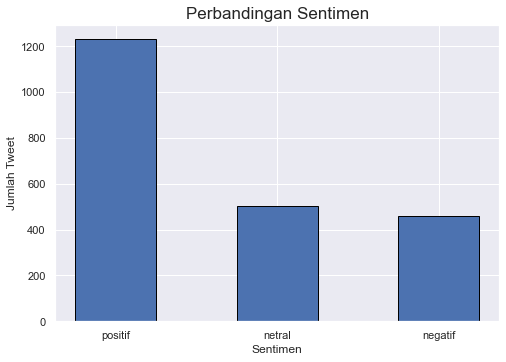

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(7,5))

# hitung frekuensi dari masing-masing nilai pada kolom 'Produk'
class_freq = data_twt['label_prediksi'].value_counts()
# membuat bar plot dengan method `plt.bar()` dari matplotlib
plt.bar(x=class_freq.index, height=class_freq.values, align='center',  edgecolor = 'black', width= 0.5)
plt.title('Perbandingan Sentimen', size=17)
plt.tight_layout()
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')

plt.savefig('dataset uji/grafik batang.png', dpi=200)
plt.show()

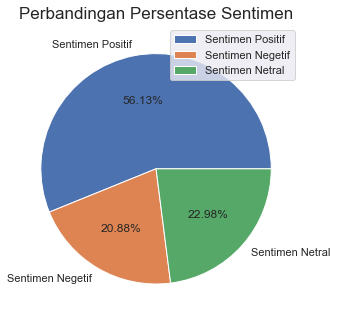

In [23]:
sentimen = ['Sentimen Positif', 'Sentimen Negetif', 'Sentimen Netral'] 
slices = [(data_twt['label_prediksi'] == "positif").sum(), (data_twt['label_prediksi'] == "negatif").sum(), (data_twt['label_prediksi'] == "netral").sum()] 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(slices,labels=sentimen,autopct='%1.2f%%')
fig = plt.gcf()
fig.set_size_inches(4,4) 
plt.title('Perbandingan Persentase Sentimen', size=17)
plt.legend()
plt.savefig('dataset uji/grafik pie.png', bbox_inches='tight', dpi=200)
plt.show()

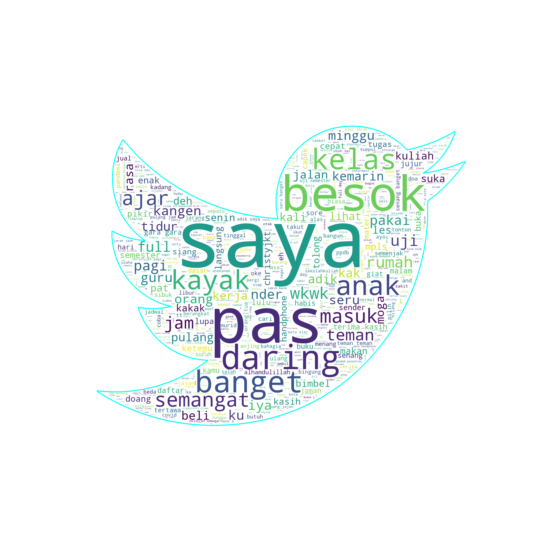

In [24]:
twitter_mask = np.array(Image.open("assets/twitter-logo.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_twitter_mask = np.ndarray((twitter_mask.shape[0],twitter_mask.shape[1]), np.int32)
for i in range(len(twitter_mask)):
    transformed_twitter_mask[i] = list(map(transform_format, twitter_mask[i]))

tweet_positif = data_twt[data_twt['label_prediksi'] == 'positif']
all_text_positif = ' '.join(word for word in tweet_positif['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='aqua', stopwords=['sekolah', 'offline']).generate(all_text_positif)
wordcloud.to_file('dataset uji/wc-positif.png')

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

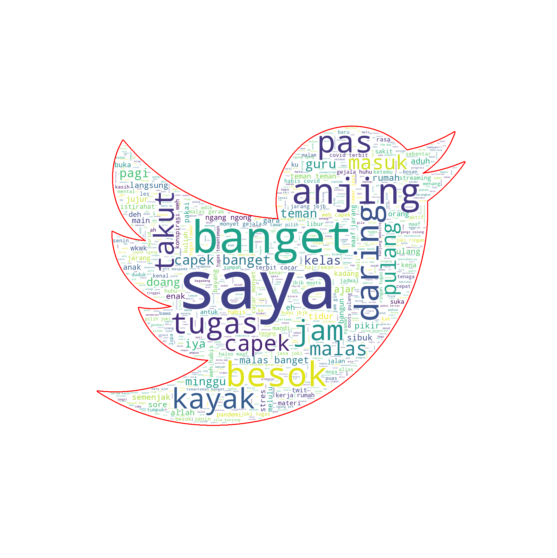

In [25]:
tweet_negatif = data_twt[data_twt['label_prediksi'] == 'negatif']
all_text_negatif = ' '.join(word for word in tweet_negatif['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='red', stopwords=['sekolah', 'offline']).generate(all_text_negatif)
wordcloud.to_file('dataset uji/wc-negatif.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

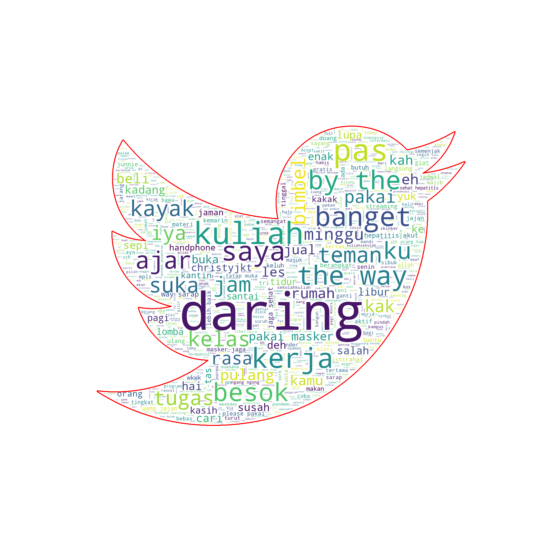

In [26]:
tweet_netral = data_twt[data_twt['label_prediksi'] == 'netral']
all_text_netral = ' '.join(word for word in tweet_netral['tweet_bersih'])
wordcloud = WordCloud(width=1000, height=1000, background_color='White',
                      mask=transformed_twitter_mask, max_words=1000,
                      contour_width=3, contour_color='red', stopwords=['sekolah', 'offline']).generate(all_text_netral)
wordcloud.to_file('dataset uji/wc-netral.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [27]:
data_twt[['tweet', 'label_prediksi']].head(10)

,tweet,label_prediksi
0,ASTAGAAAA BARU INGET SEKARANG SEKOLAH OFFLINE,negatif
1,"Yg udh sekolah offline, lama lama bosan gsi se...",negatif
2,@jinhwanchy Wah udah sekolah offline? Semangat...,positif
3,"@Fajri_UN1TY Haii juga, yuk yg sekolah offline...",positif
4,Sch! Hai gais hari ini sender PTM untuk yg per...,positif
5,"adek semua uda mulai sekolah offline, ini kaka...",positif
6,sekolah offline/online ?,netral
7,Sekolah lg.... Mana ud offline papay guyss,negatif
8,"morning, hari ini sekolah offline/online?",netral
9,sch! wtp sender udah sekolah offline nii... tt...,positif


In [29]:
filename = 'NewDataset/hasil-klasifikasi.csv'
data_twt.to_csv(filename, columns=['tweet', 'label_prediksi'], index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'NewDataset/hasil-klasifikasi.csv'